## Step 1: Minimax Implementation with Randomization for Kane
To implement the Minimax algorithm with randomization for Kane, we will follow these steps:

- Install necessary libraries.
- Implement the deterministic version of the Minimax algorithm.
- Introduce randomization to the evaluation function and move selection.
- Simulate games using both deterministic and randomized algorithms.
- Collect and analyze performance metrics.
- Generate equivalence curves to compare the deterministic and randomized algorithms.

In [ ]:
!pip install python-chess numpy pandas matplotlib seaborn




[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# 2. Implement the deterministic version of the Minimax algorithm with heuristic evaluation

import chess
from collections import defaultdict

# Deterministic Minimax Implementation
class KaneMinimaxDeterministic:
    def __init__(self, board):
        self.board = board
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count
        return score

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


In [ ]:
# 3. Introduce randomization to the evaluation function and move selection

# Pseudorandom Generator (PRG)
class PseudoRandom:
    def __init__(self, seed):
        self.state = seed

    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)

# Randomized Evaluation Function
class KaneMinimaxRandomization:
    def __init__(self, board, seed):
        self.board = board
        self.prng = PseudoRandom(seed)
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function with random component
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count

        # Random adjustment
        random_adjustment = int((self.prng.random() - 0.5) * 10)  # Random adjustment between -5 and +5
        return score + random_adjustment

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


In [ ]:
# 4. Simulate games using both deterministic and randomized algorithms

import time
import pandas as pd
from IPython.display import clear_output, display, SVG
import chess.svg
import numpy as np

# Function to calculate additional metrics
def calculate_metrics(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    return material_count, mobility_count, piece_square_score, center_control_count

def calculate_additional_metrics(board, move_scores, current_depth, is_exploratory):
    evaluation_score = sum(move_scores) / len(move_scores) if move_scores else 0
    branching_factor = len(list(board.legal_moves))
    depth_of_search = current_depth
    move_diversity = np.var(move_scores) if move_scores else 0
    exploration_vs_exploitation = 1 if is_exploratory else 0
    return evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation

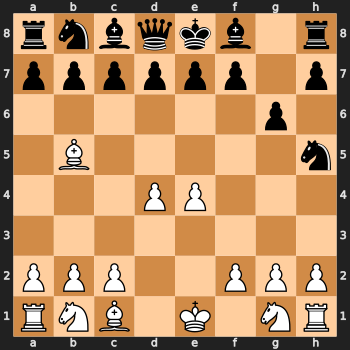

Move: d2d4
Step: 8, Time: 53.413769006729126, Material: -1, Mobility: 20, Piece-Square: -1, Center Control: 2
Stop the game in advance!
Result: *
   Step       Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1  25.708093  e2e4               0              20                   0   
1     2  50.734283  g8f6               0              30                   0   
2     3  60.736143  f1b5               0              19                   0   
3     4  50.405963  g7g6               0              34                   0   
4     5  64.696226  d1h5               0              20                   0   
5     6  90.765619  f6h5              -1              31                  -1   
6     7  53.413769  d2d4              -1              20                  -1   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              37.0                20                3   
1                     1               8.0            

In [ ]:
# Function to play the game with deterministic Minimax
def play_game_minimax_deterministic(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

# Simulate and run the deterministic game
print("Running deterministic game...")
deterministic_results = [play_game_minimax_deterministic(kane_deterministic)]

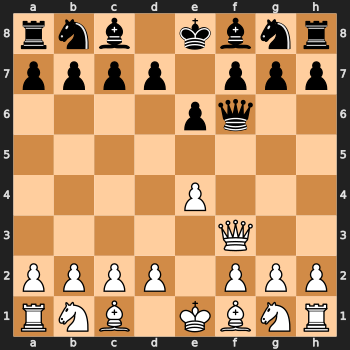

Move: d8f6
Step: 5, Time: 146.27900671958923, Material: 0, Mobility: 38, Piece-Square: 0, Center Control: 1
Stop the game in advance!
Result: *
   Step        Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1   25.863384  e2e4               0              20                   0   
1     2   51.126204  e7e6               0              30                   0   
2     3  100.658508  d1f3               0              30                   0   
3     4  146.279007  d8f6               0              38                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              35.0                20                3   
1                     1              10.0                30                3   
2                     1              29.0                30                3   
3                     1              23.0                38                3   

   Move Diversity  Exploration vs Exploitation  


In [ ]:
# Function to play the game with randomized Minimax
def play_game_minimax_randomized(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Simulate and run the randomized game
print("Running randomized game...")
randomized_results = [play_game_minimax_randomized(kane_randomized)]

In [ ]:
# 5. Collect and analyze performance metrics

# Collect evaluation consistency data
evaluation_consistency_df = pd.DataFrame.from_dict(kane_deterministic.evaluation_consistency, orient='index').transpose()
evaluation_consistency_df = evaluation_consistency_df.ffill()

# Collect move stability data
move_stability_df = pd.DataFrame.from_dict(kane_deterministic.move_stability, orient='index', columns=['Move Stability'])

# Collect search path data
search_paths_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in kane_deterministic.search_paths.items()]))

# Debugging print statements
print("Evaluation Consistency DataFrame:\n", evaluation_consistency_df.head())
print("Move Stability DataFrame:\n", move_stability_df.head())
print("Search Paths DataFrame:\n", search_paths_df.head())

# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Convert results to DataFrames
deterministic_results = [ensure_dataframe(df) for df in deterministic_results]
randomized_results = [ensure_dataframe(df) for df in randomized_results]

# Print structures for debugging
print("\nDeterministic Results Sample:\n", deterministic_results[0].head() if deterministic_results else "No Data")
print("\nRandomized Results Sample:\n", randomized_results[0].head() if randomized_results else "No Data")

# Aggregate and analyze the results
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    # Ensure results is a list of DataFrame objects
    aggregated_data = pd.concat(results, ignore_index=True)
    
    # Print columns to debug
    print("\nAggregated Data Columns:\n", aggregated_data.columns)
    
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    
    return mean_metrics, std_metrics, aggregated_data

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Display the aggregated metrics
print("Deterministic Mean Metrics:\n", deterministic_mean)
print("Deterministic Std Metrics:\n", deterministic_std)
print("\nRandomized Mean Metrics:\n", randomized_mean)
print("Randomized Std Metrics:\n", randomized_std)

# Display move sequences and non-numeric data
print("\nDeterministic Moves:\n", deterministic_data['Move'])
print("\nRandomized Moves:\n", randomized_data['Move'])

Evaluation Consistency DataFrame:
     4352146737187081421   7616511019056131451   6518554579016092914  \
0                  25.0                  25.0                  25.0   
1                  25.0                  25.0                  25.0   
2                  25.0                  25.0                  25.0   
3                  25.0                  25.0                  25.0   
4                  25.0                  25.0                  25.0   

    4863442088289023053   4441733144372083048  -1695821553158785235  \
0                  25.0                  25.0                  24.0   
1                  25.0                  25.0                  24.0   
2                  25.0                  25.0                  24.0   
3                  25.0                  25.0                  24.0   
4                  25.0                  25.0                  24.0   

    8861709415591664965  -5441294205232891155   7125774524175957764  \
0                  25.0                 


Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')

Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')
Deterministic Mean Metrics:
 Material Count                 -0.285714
Mobility Count                 24.857143
Piece-Square Score             -0.285714
Center Control Count            1.142857
Evaluation Score               22.571429
Branching Factor               24.857143
Depth of Search                 3.000000
Move Diversity                  0.000000
Exploration vs Exploitation     0.000000
dtype: float64
Det

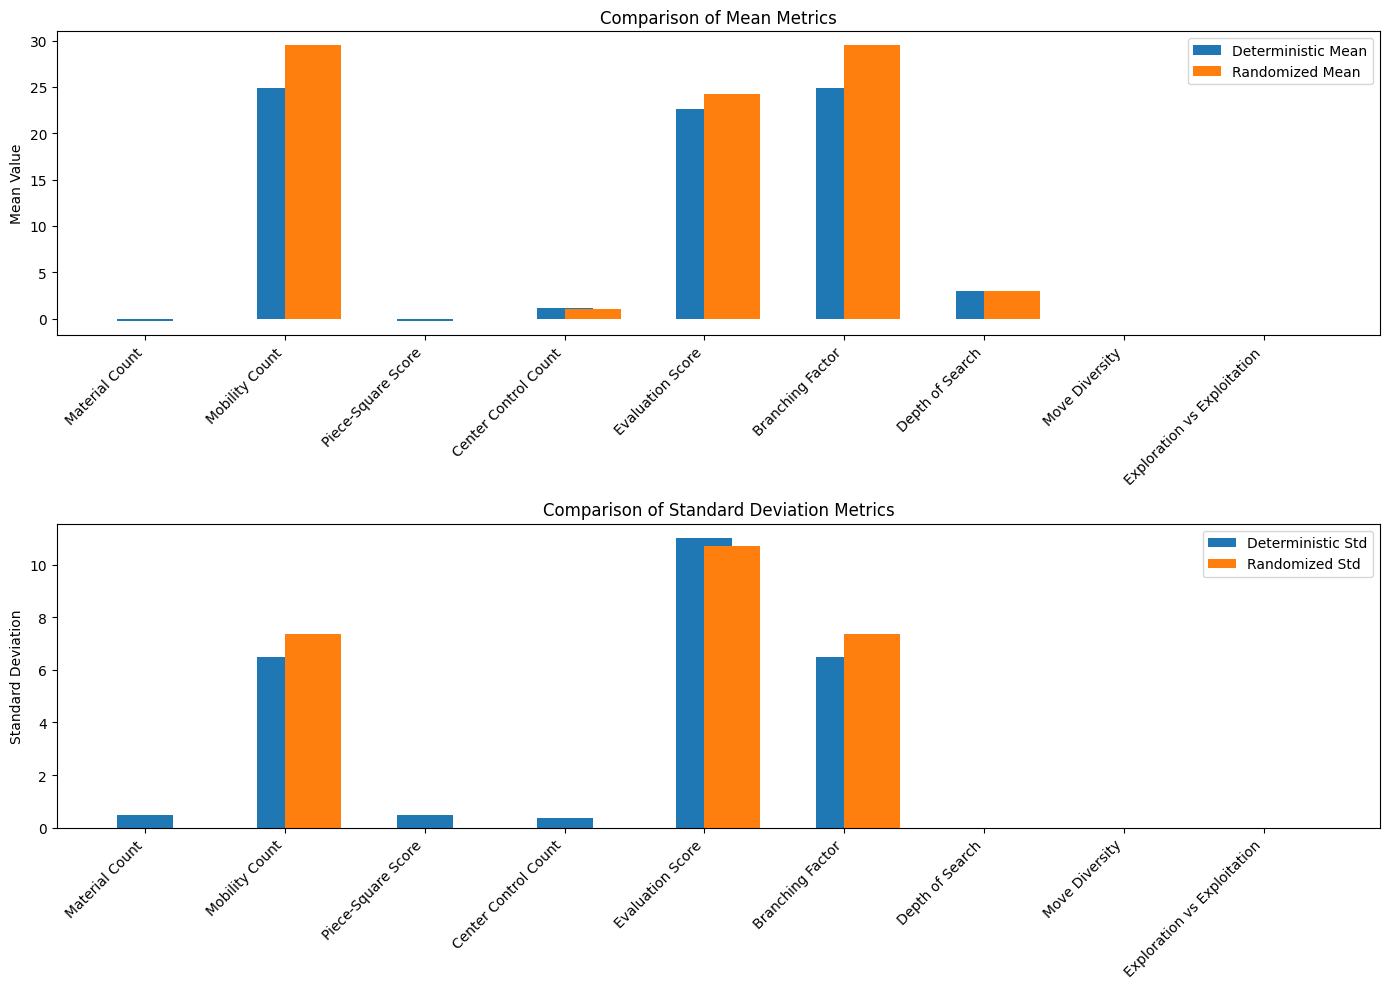

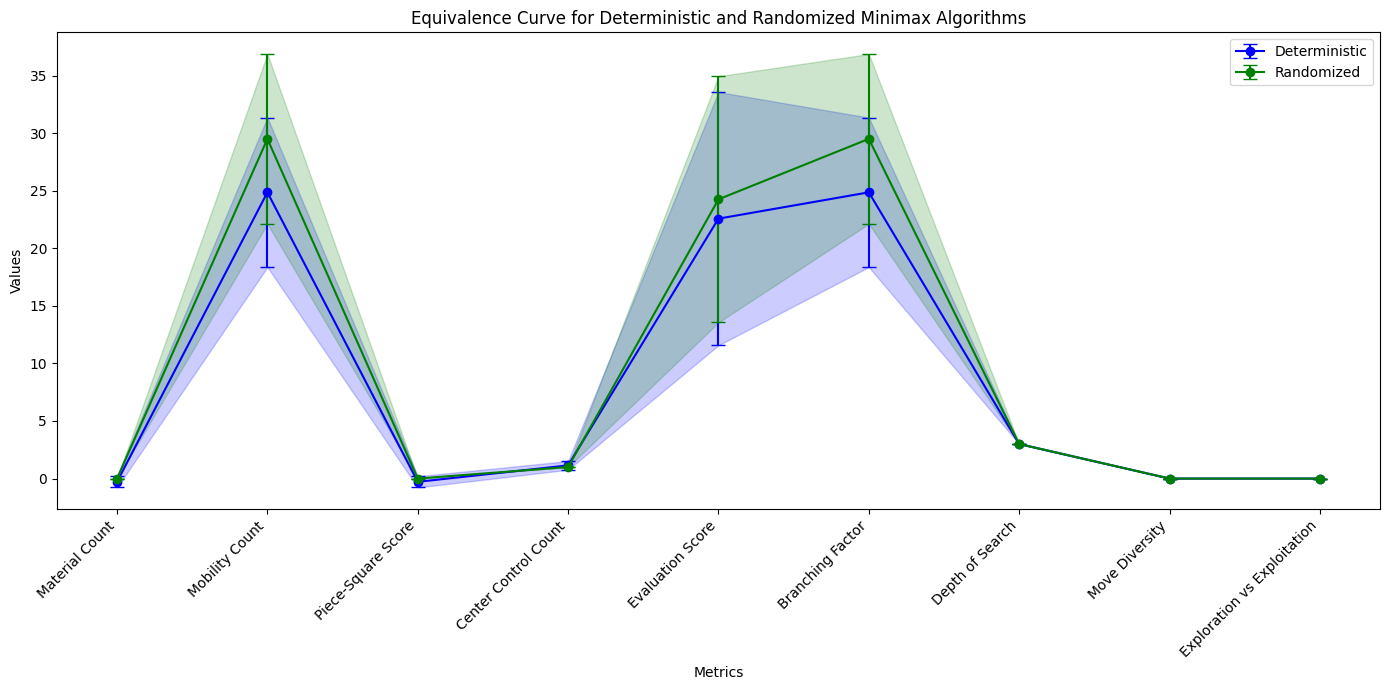

In [ ]:
# 6. Compare the deterministic and randomized algorithms and generate equivalence curves

import matplotlib.pyplot as plt

# Function to compare Kane versions
def compare_kane_versions(deterministic_results, randomized_results):
    deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
    randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

    # Display the aggregated metrics
    print("Deterministic Mean Metrics:\n", deterministic_mean)
    print("Deterministic Std Metrics:\n", deterministic_std)
    print("\nRandomized Mean Metrics:\n", randomized_mean)
    print("Randomized Std Metrics:\n", randomized_std)

    # Plot comparison metrics
    def plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = range(len(metrics))

        fig, axs = plt.subplots(2, 1, figsize=(14, 10))

        # Plot means
        axs[0].bar(x, deterministic_mean, width=0.4, label='Deterministic Mean', align='center')
        axs[0].bar(x, randomized_mean, width=0.4, label='Randomized Mean', align='edge')
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(metrics, rotation=45, ha='right')
        axs[0].set_ylabel('Mean Value')
        axs[0].set_title('Comparison of Mean Metrics')
        axs[0].legend()

        # Plot standard deviations
        axs[1].bar(x, deterministic_std, width=0.4, label='Deterministic Std', align='center')
        axs[1].bar(x, randomized_std, width=0.4, label='Randomized Std', align='edge')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(metrics, rotation=45, ha='right')
        axs[1].set_ylabel('Standard Deviation')
        axs[1].set_title('Comparison of Standard Deviation Metrics')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    # Plot comparison metrics
    plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

    # Plot equivalence curve
    def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = np.arange(len(metrics))

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(14, 7))

        # Plot deterministic means with error bars for std
        ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

        # Plot randomized means with error bars for std
        ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

        # Fill between for deterministic std
        ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

        # Fill between for randomized std
        ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

        # Add title and labels
        ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')

        # Add legend
        ax.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

    # Plot equivalence curve
    plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

# Compare the results
compare_kane_versions(deterministic_results, randomized_results)


## Step 2: Verification and Conclusion
To verify the potential equivalence between the deterministic and randomized versions of the Minimax algorithm, we will:

- Simulate multiple games using both versions.
- Collect and aggregate performance metrics.
- Generate and analyze equivalence curves.
- Perform statistical tests to validate the results.

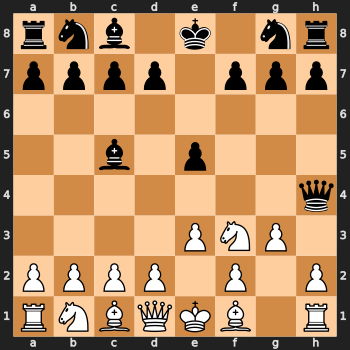

Move: d8h4
Step: 7, Time: 122.0768392086029, Material: 0, Mobility: 29, Piece-Square: 0, Center Control: 1
Stop the game in advance!
Result: *
   Step        Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1   14.125608  g1f3               0              20                   0   
1     2   25.229803  e7e5               0              22                   0   
2     3   60.397458  e2e3               0              30                   0   
3     4   95.076922  f8c5               0              28                   0   
4     5  104.117771  g2g3               0              33                   0   
5     6  122.076839  d8h4               0              29                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     0              22.0                20                3   
1                     1              17.0                22                3   
2                     1               4.5        

In [ ]:
# 1. Simulate multiple games

def compare_kane_versions(deterministic_kane, randomized_kane, depth=3, games=5, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        # Play game with deterministic Kane
        deterministic_kane.board.reset()
        deterministic_data = play_game_minimax_deterministic(deterministic_kane, depth, max_moves, max_runtime)
        deterministic_results.append(deterministic_data)

        # Play game with randomized Kane
        randomized_kane.board.reset()
        randomized_data = play_game_minimax_randomized(randomized_kane, depth, max_moves, max_runtime)
        randomized_results.append(randomized_data)

    return deterministic_results, randomized_results

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Compare the two versions over multiple games
deterministic_results, randomized_results = compare_kane_versions(kane_deterministic, kane_randomized)


In [ ]:
# 2. Collect and aggregate performance metrics

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Display the aggregated metrics
print("Deterministic Mean Metrics:\n", deterministic_mean)
print("Deterministic Std Metrics:\n", deterministic_std)
print("\nRandomized Mean Metrics:\n", randomized_mean)
print("Randomized Std Metrics:\n", randomized_std)



Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')

Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')
Deterministic Mean Metrics:
 Material Count                 -0.06250
Mobility Count                 25.31250
Piece-Square Score             -0.06250
Center Control Count            0.71875
Evaluation Score               21.65625
Branching Factor               25.31250
Depth of Search                 3.00000
Move Diversity                  0.00000
Exploration vs Exploitation     0.00000
dtype: float64
Deterministi

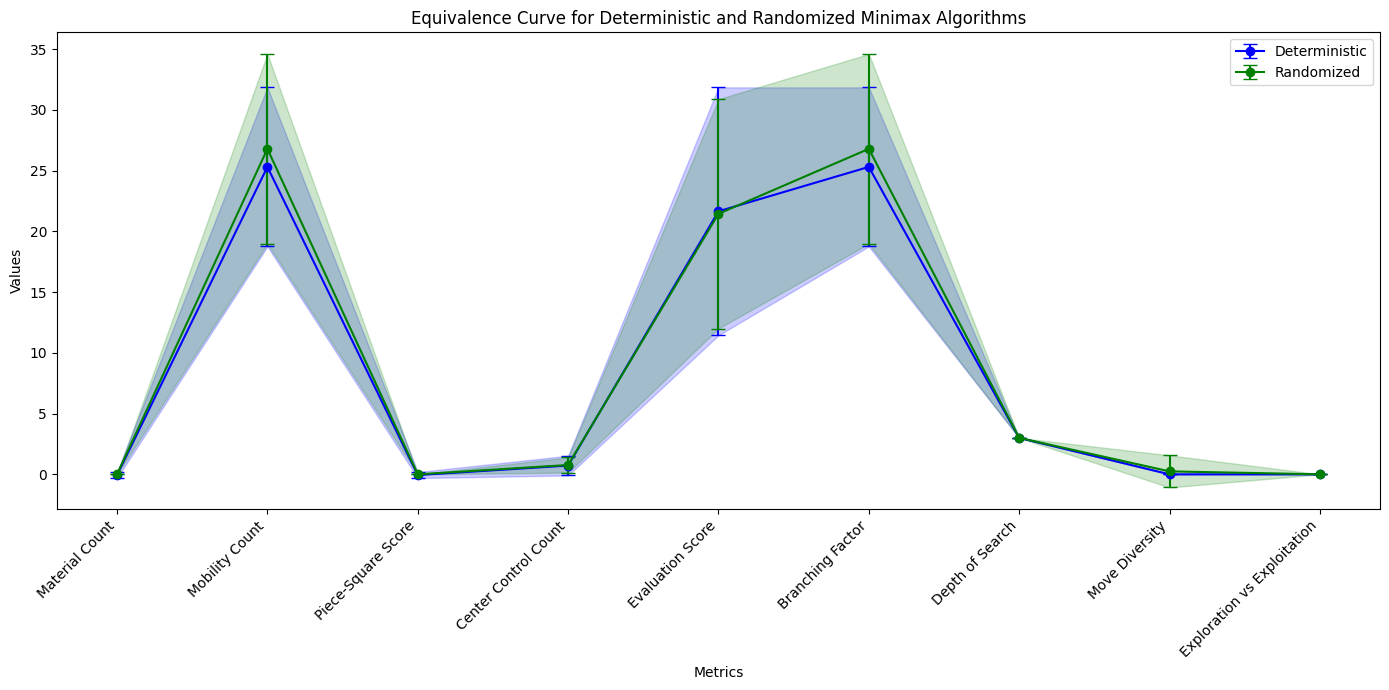

In [ ]:
# 3. Generate and analyze equivalence curves

# Plot equivalence curve
plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)



In [ ]:
# 4. Perform statistical tests

# Statistical Analysis
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(deterministic_metrics, randomized_metrics):
    results = {}
    for metric in deterministic_metrics.index:
        t_stat, p_value_t = ttest_ind(deterministic_data[metric], randomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(deterministic_data[metric], randomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(deterministic_mean, randomized_mean)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")



Material Count: t-statistic = -1.4375905768565218, p-value (t-test) = 0.16056863389412462
Material Count: f-statistic = 1.9354838709677415, p-value (F-test) = 0.16929712120066065

Mobility Count: t-statistic = -0.809969057564026, p-value (t-test) = 0.4213410560455605
Mobility Count: f-statistic = 0.6636038423198253, p-value (F-test) = 0.4185121607826926

Piece-Square Score: t-statistic = -1.4375905768565218, p-value (t-test) = 0.16056863389412462
Piece-Square Score: f-statistic = 1.9354838709677415, p-value (F-test) = 0.16929712120066065

Center Control Count: t-statistic = -0.2610227638918955, p-value (t-test) = 0.7950014644107849
Center Control Count: f-statistic = 0.06700287728171819, p-value (F-test) = 0.7966376164183806

Evaluation Score: t-statistic = 0.08264640867333699, p-value (t-test) = 0.9344078428512188
Evaluation Score: f-statistic = 0.006795784256280596, p-value (F-test) = 0.934573975772429

Branching Factor: t-statistic = -0.809969057564026, p-value (t-test) = 0.42134105

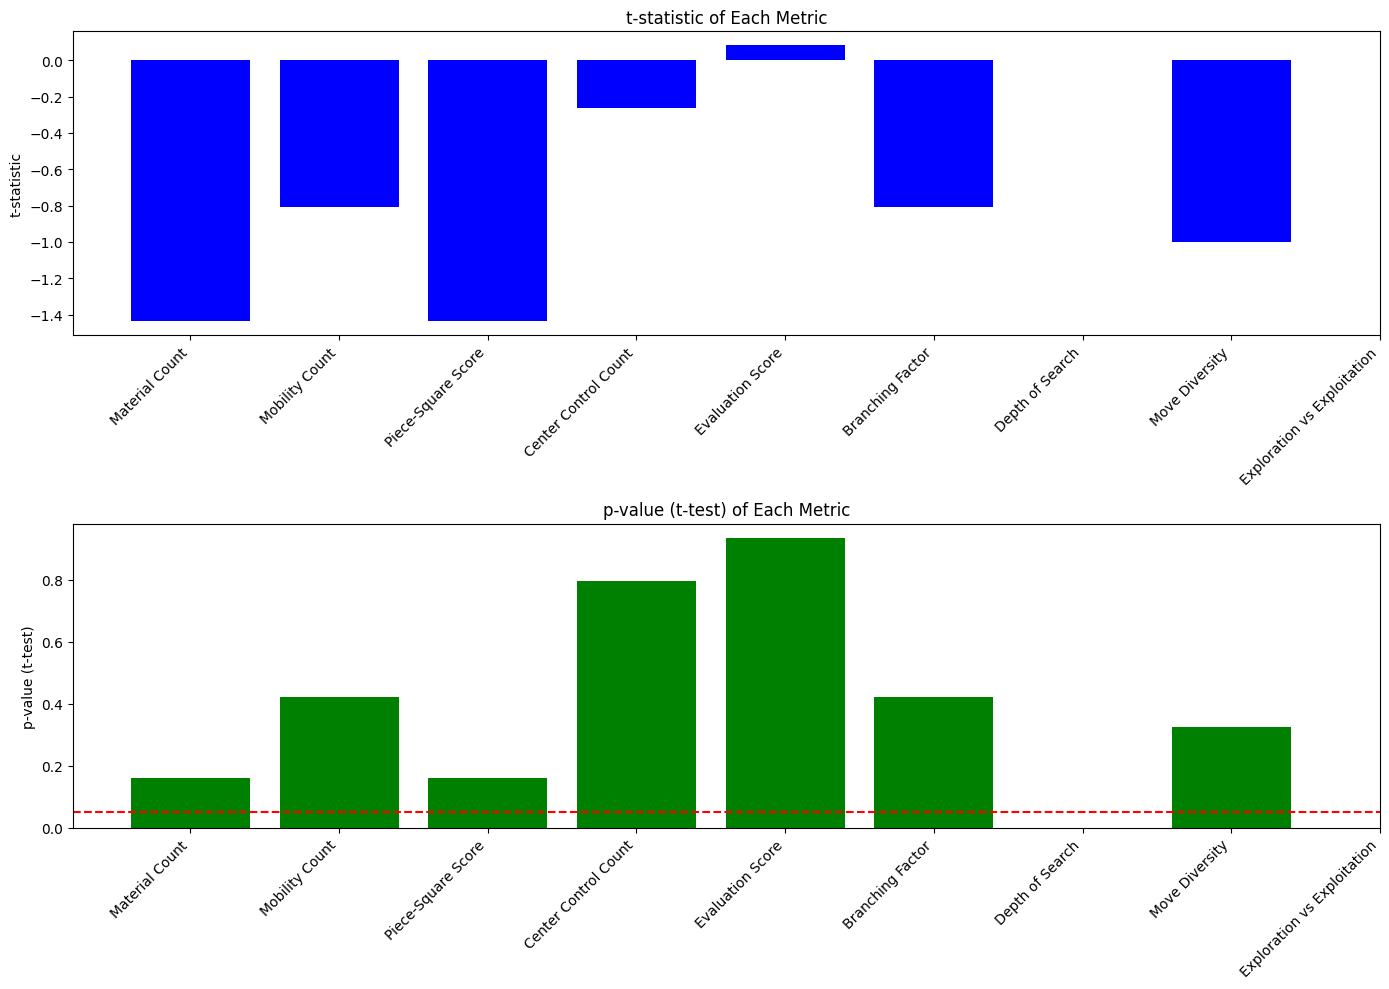

In [ ]:
# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)

In [ ]:

def compare_kane_versions(deterministic_kane, randomized_kane, depth=3, games=5, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        # Play game with deterministic Kane
        deterministic_kane.board.reset()
        deterministic_data = play_game_minimax_deterministic(deterministic_kane, depth, max_moves, max_runtime)
        deterministic_results.append(deterministic_data)

        # Play game with randomized Kane
        randomized_kane.board.reset()
        randomized_data = play_game_minimax_randomized(randomized_kane, depth, max_moves, max_runtime)
        randomized_results.append(randomized_data)

    return deterministic_results, randomized_results

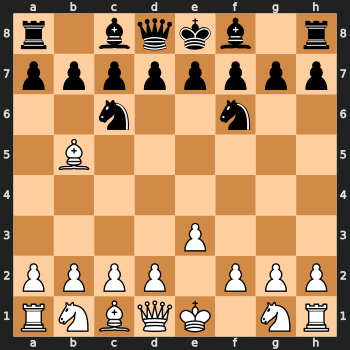

Move: b8c6
Step: 5, Time: 49.402199506759644, Material: 0, Mobility: 33, Piece-Square: 0, Center Control: 0


KeyboardInterrupt: 

In [ ]:
# # Run additional games to gather more data
# additional_games = 10
# deterministic_results_additional, randomized_results_additional = compare_kane_versions(kane_deterministic, kane_randomized, games=additional_games)

# # Aggregate the additional data
# deterministic_mean_additional, deterministic_std_additional, deterministic_data_additional = aggregate_metrics(deterministic_results_additional)
# randomized_mean_additional, randomized_std_additional, randomized_data_additional = aggregate_metrics(randomized_results_additional)

# # Combine the original and additional data
# combined_deterministic_data = pd.concat([deterministic_data, deterministic_data_additional], ignore_index=True)
# combined_randomized_data = pd.concat([randomized_data, randomized_data_additional], ignore_index=True)

# # Recalculate the means and standard deviations
# combined_deterministic_mean, combined_deterministic_std = combined_deterministic_data.mean(), combined_deterministic_data.std()
# combined_randomized_mean, combined_randomized_std = combined_randomized_data.mean(), combined_randomized_data.std()

# # Display the combined metrics
# print("Combined Deterministic Mean Metrics:\n", combined_deterministic_mean)
# print("Combined Deterministic Std Metrics:\n", combined_deterministic_std)
# print("\nCombined Randomized Mean Metrics:\n", combined_randomized_mean)
# print("Combined Randomized Std Metrics:\n", combined_randomized_std)

# # Equivalence Curve
# def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
#     metrics = deterministic_mean.index
#     x = np.arange(len(metrics))

#     # Create figure and axis
#     fig, ax = plt.subplots(figsize=(14, 7))

#     # Plot deterministic means with error bars for std
#     ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

#     # Plot randomized means with error bars for std
#     ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

#     # Fill between for deterministic std
#     ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

#     # Fill between for randomized std
#     ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

#     # Add title and labels
#     ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
#     ax.set_xlabel('Metrics')
#     ax.set_ylabel('Values')
#     ax.set_xticks(x)
#     ax.set_xticklabels(metrics, rotation=45, ha='right')

#     # Add legend
#     ax.legend()

#     # Show plot
#     plt.tight_layout()
#     plt.show()

# # Plot equivalence curve
# plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)


## Simple NN Abel and Its Derandomization


In [ ]:
# Step 1: Install necessary libraries

!pip install tensorflow numpy pandas matplotlib seaborn chess


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Step 2: Define the Simple Neural Network for Abel

# 2.1: Import Required Libraries and Define Helper Functions

import chess
import chess.svg
from IPython.display import display, clear_output, SVG
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway


# Setting up constants
gamma = 0.95
batch_size = 32
target_update_freq = 10

# Helpers for derandomization
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def softmax_policy(q_values, temperature):
    q_values = np.array(q_values)  # Convert list to numpy array
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.argmax(probabilities)

In [ ]:
# Heuristic Evaluation

def heuristic_evaluation(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    score = material_count + mobility_count + piece_square_score + center_control_count
    return score

In [ ]:
# Define the Game Environment

class ChessEnv:
    def __init__(self):
        self.board = chess.Board()
    
    def reset(self):
        self.board.reset()
        return self.board
    
    def step(self, state, action):
        self.board.push(action)
        reward = heuristic_evaluation(self.board)
        done = self.board.is_game_over()
        return self.board, reward, done
    
    def legal_moves(self, state):
        return list(state.legal_moves)
    
    def simulate_move(self, state, move):
        temp_board = state.copy()
        temp_board.push(move)
        return temp_board

In [ ]:
# Define the Simple NN Model

class AbelNN:
    def __init__(self, seed):
        self.model = self.build_model(seed)
    
    def build_model(self, seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        model = Sequential([
            Flatten(input_shape=(8, 8, 12)),  # Ensure this matches the shape of the input
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model
    
    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]
    
    def board_to_input(self, board):
        input_array = np.zeros((8, 8, 12))
        piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                x, y = divmod(square, 8)
                input_array[x, y, piece_to_index[piece.symbol()]] = 1
        return np.array([input_array])


In [ ]:
# Step 3: Training Functions

# 3.1: Training the Original Simple NN

def train_simple_nn(env, num_episodes=10, seed=42, temperature=1.0):
    nn = AbelNN(seed)
    set_random_seed(seed)
    
    for e in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            q_values = [nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            target = reward + heuristic_evaluation(next_state)
            state_input = nn.board_to_input(state)
            nn.model.fit(state_input, np.array([target]), epochs=1, verbose=0)
            state = next_state

    return nn


In [ ]:
# Training the original Simple NN
print("Training the original Simple NN...")
env = ChessEnv()
abel_nn_probabilistic = train_simple_nn(env, num_episodes=5, seed=42, temperature=1.0)

Training the original Simple NN...


In [ ]:
# 3.2: Training the Derandomized Simple NN

# Training the derandomized Simple NN
def update_nn(abel_nn, target_network, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * np.array(target_q_values)
    states = np.array([abel_nn.board_to_input(state).reshape(-1, 8, 8, 12) for state in states])
    targets = np.array(targets).reshape(-1, 1)  # Ensure targets are in correct shape
    print(f"Updating NN: states shape: {states.shape}, targets shape: {targets.shape}")  # Debugging info
    abel_nn.model.train_on_batch(np.vstack(states), targets)

def train_abel_nn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    abel_nn = AbelNN(seed)
    target_network = AbelNN(seed)
    replay_buffer = []
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_nn(abel_nn, target_network, batch)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(abel_nn.model.get_weights())
    
    return abel_nn


In [ ]:
# Training the derandomized Simple NN
print("Training the derandomized Simple NN...")
env = ChessEnv()
abel_nn_derandomized = train_abel_nn_derandomized(env, num_episodes=5, seed=42, temperature=1.0)


Training the derandomized Simple NN...
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32

In [ ]:
# 4. Simulate Games using simple NN

# 4.1: Play Game with Probabilistic NN

def play_game_nn_probabilistic(abel_nn, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        # Calculate additional metrics
        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3  # Placeholder value
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0  # Placeholder value

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


In [ ]:
# 4.3: Function to Play the Game with Derandomized NN

def play_game_nn_derandomized(abel_nn, env, max_moves=55, max_runtime=600, temperature=0.5):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        # Calculate additional metrics
        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3  # Placeholder value
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0  # Placeholder value

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


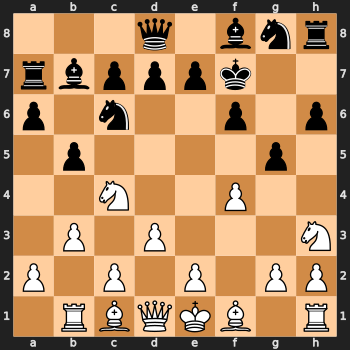

Move: g7f8, Step: 35, Time: 1.2084355354309082, Material: 32
Result: 1/2-1/2


In [ ]:
# 5. Compare Abel Versions

def compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=1, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []

    for _ in range(games):
        # Play game with probabilistic NN
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)

        # Play game with derandomized NN
        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)

    return probabilistic_results, derandomized_results

# Compare the two versions over multiple games
probabilistic_results, derandomized_results = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=5)


In [ ]:
# 6: Collect data 

# 6.1: Aggregate Metrics

# Define numeric columns at the beginning
numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                   'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                   'Exploration vs Exploitation']

# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Function to aggregate metrics
def aggregate_metrics(results):
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    return mean_metrics, std_metrics, aggregated_data

# Convert results to DataFrames
probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

# Aggregate the results
probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)
derandomized_mean, derandomized_std, derandomized_data = aggregate_metrics(derandomized_results)

# Display the aggregated metrics
print("Probabilistic NN Mean Metrics:\n", probabilistic_mean)
print("Probabilistic NN Std Metrics:\n", probabilistic_std)
print("\nDerandomized NN Mean Metrics:\n", derandomized_mean)
print("Derandomized NN Std Metrics:\n", derandomized_std)

# Display move sequences and non-numeric data
print("\nProbabilistic Moves:\n", probabilistic_data['Move'])
print("\nDerandomized Moves:\n", derandomized_data['Move'])


Probabilistic NN Mean Metrics:
 Material Count                  26.346154
Mobility Count                  25.653846
Piece-Square Score               0.000000
Center Control Count             0.692308
Evaluation Score                52.268654
Branching Factor                25.653846
Depth of Search                  3.000000
Move Diversity                 167.855769
Exploration vs Exploitation      0.000000
dtype: float64
Probabilistic NN Std Metrics:
 Material Count                  3.682583
Mobility Count                  3.564927
Piece-Square Score              0.000000
Center Control Count            0.463324
Evaluation Score                3.125356
Branching Factor                3.564927
Depth of Search                 0.000000
Move Diversity                 44.396697
Exploration vs Exploitation     0.000000
dtype: float64

Derandomized NN Mean Metrics:
 Material Count                  26.205882
Mobility Count                  26.205882
Piece-Square Score               0.000000
Ce

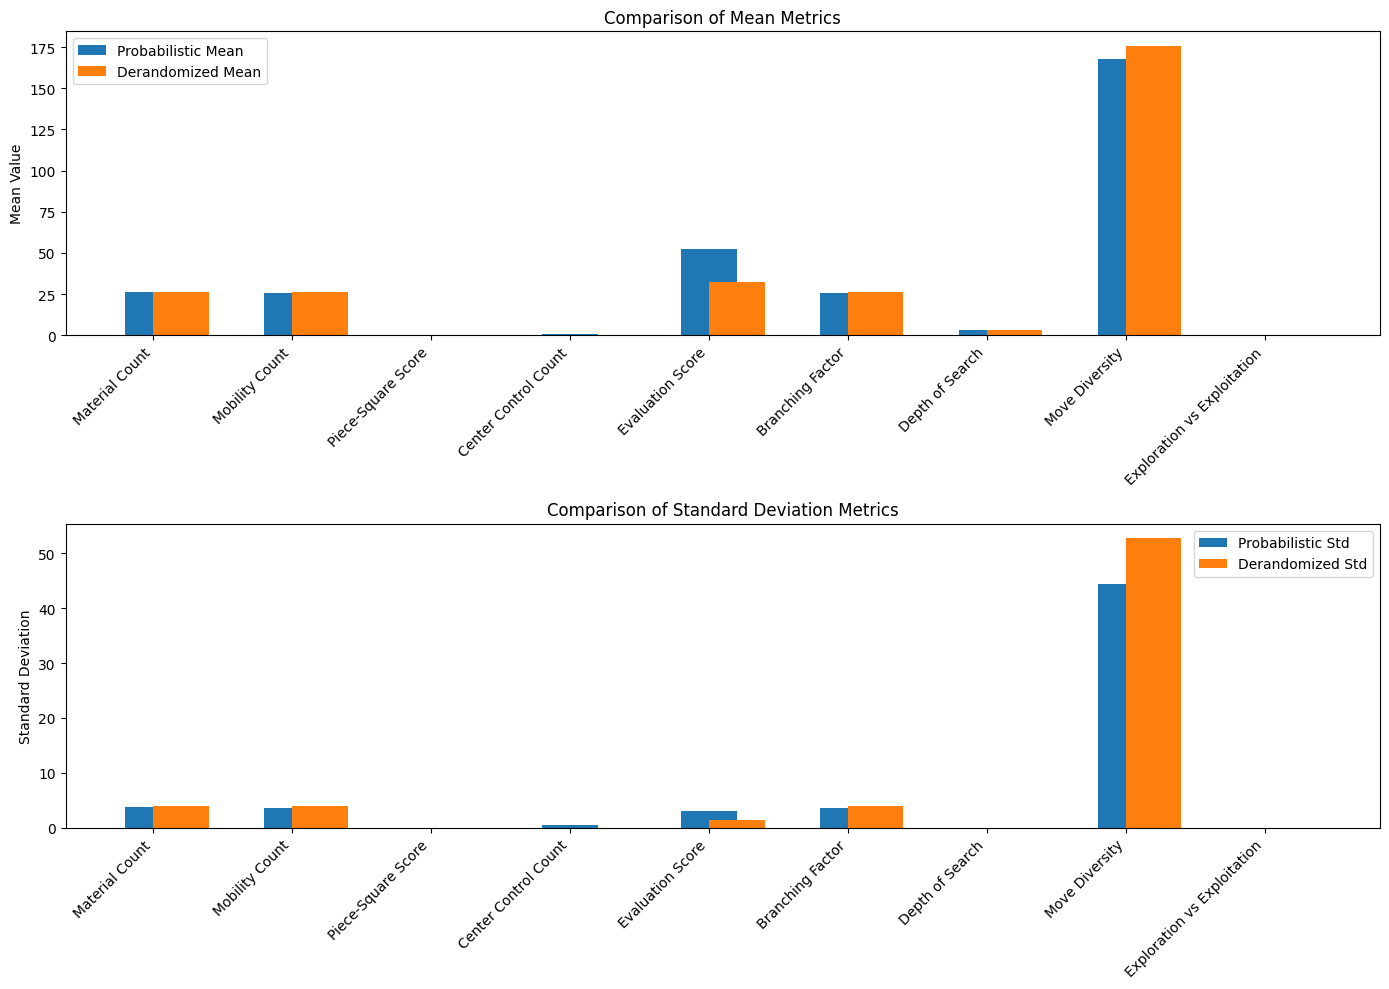

In [ ]:
# 7: Plot Comparison Metrics and Equivalence Curve

# Plot comparison metrics
def plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std):
    metrics = probabilistic_mean.index
    x = range(len(metrics))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot means
    axs[0].bar(x, probabilistic_mean, width=0.4, label='Probabilistic Mean', align='center')
    axs[0].bar(x, derandomized_mean, width=0.4, label='Derandomized Mean', align='edge')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('Mean Value')
    axs[0].set_title('Comparison of Mean Metrics')
    axs[0].legend()

    # Plot standard deviations
    axs[1].bar(x, probabilistic_std, width=0.4, label='Probabilistic Std', align='center')
    axs[1].bar(x, derandomized_std, width=0.4, label='Derandomized Std', align='edge')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].set_ylabel('Standard Deviation')
    axs[1].set_title('Comparison of Standard Deviation Metrics')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the comparison metrics
plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std)



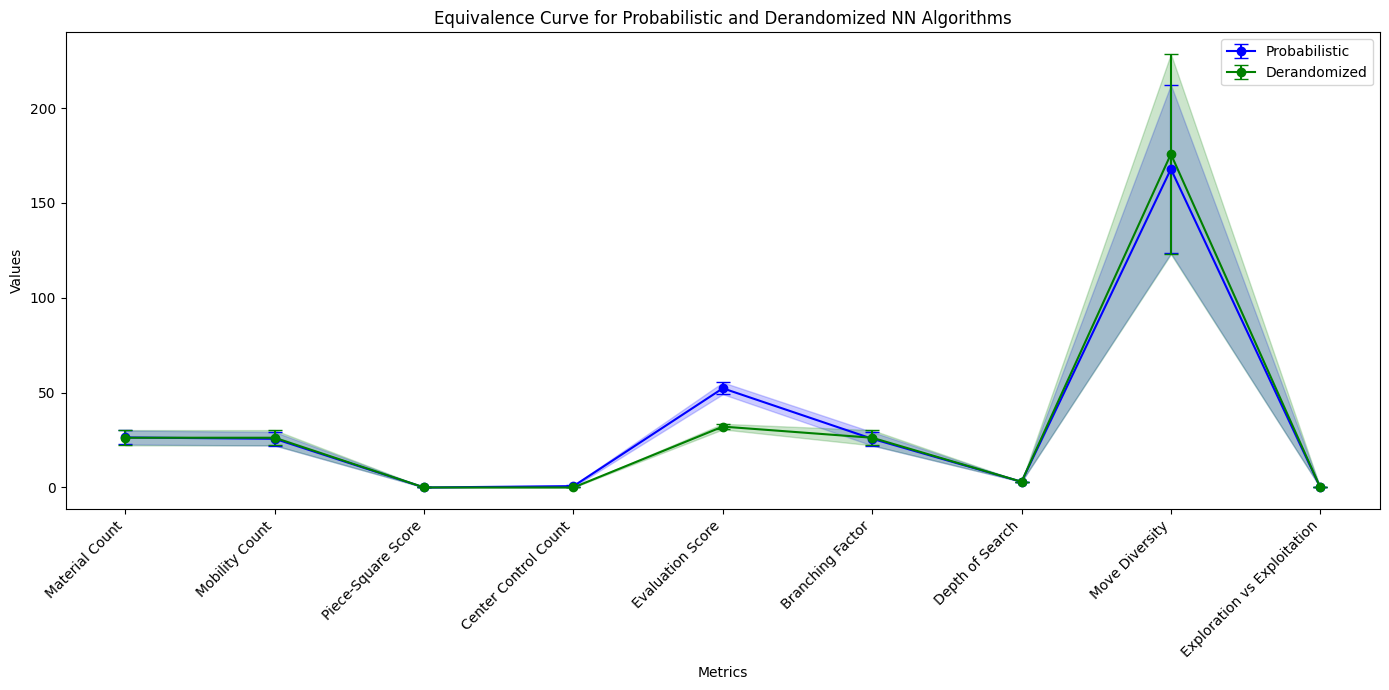

In [ ]:
# Plot equivalence curve
def plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std):
    metrics = probabilistic_mean.index
    x = np.arange(len(metrics))

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot probabilistic means with error bars for std
    ax.errorbar(x, probabilistic_mean, yerr=probabilistic_std, fmt='o-', label='Probabilistic', color='blue', capsize=5)

    # Plot derandomized means with error bars for std
    ax.errorbar(x, derandomized_mean, yerr=derandomized_std, fmt='o-', label='Derandomized', color='green', capsize=5)

    # Fill between for probabilistic std
    ax.fill_between(x, probabilistic_mean - probabilistic_std, probabilistic_mean + probabilistic_std, color='blue', alpha=0.2)

    # Fill between for derandomized std
    ax.fill_between(x, derandomized_mean - derandomized_std, derandomized_mean + derandomized_std, color='green', alpha=0.2)

    ax.set_title('Equivalence Curve for Probabilistic and Derandomized NN Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot the equivalence curve
plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std)



In [ ]:
# 8: Perform Statistical Tests

from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(probabilistic_data, derandomized_data):
    results = {}
    for metric in probabilistic_data.columns:
        if metric in ['Move', 'Step', 'Time']:
            continue
        t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(probabilistic_data[metric], derandomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(probabilistic_data, derandomized_data)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")




Material Count: t-statistic = 0.3136875014299078, p-value (t-test) = 0.753984902583335
Material Count: f-statistic = 0.09604665865098413, p-value (F-test) = 0.7568430025329245

Mobility Count: t-statistic = -1.2552721960035442, p-value (t-test) = 0.21038449276412888
Mobility Count: f-statistic = 1.5248715502496801, p-value (F-test) = 0.21785653041913586

Piece-Square Score: t-statistic = nan, p-value (t-test) = nan
Piece-Square Score: f-statistic = nan, p-value (F-test) = nan

Center Control Count: t-statistic = 17.03672503740082, p-value (t-test) = 8.085666812422832e-35
Center Control Count: f-statistic = 379.95000000000016, p-value (F-test) = 3.9705101352835365e-55

Evaluation Score: t-statistic = 68.02548877212793, p-value (t-test) = 5.3557936904513145e-127
Evaluation Score: f-statistic = 5482.062492036494, p-value (F-test) = 6.399691007177971e-194

Branching Factor: t-statistic = -1.2552721960035442, p-value (t-test) = 0.21038449276412888
Branching Factor: f-statistic = 1.524871550

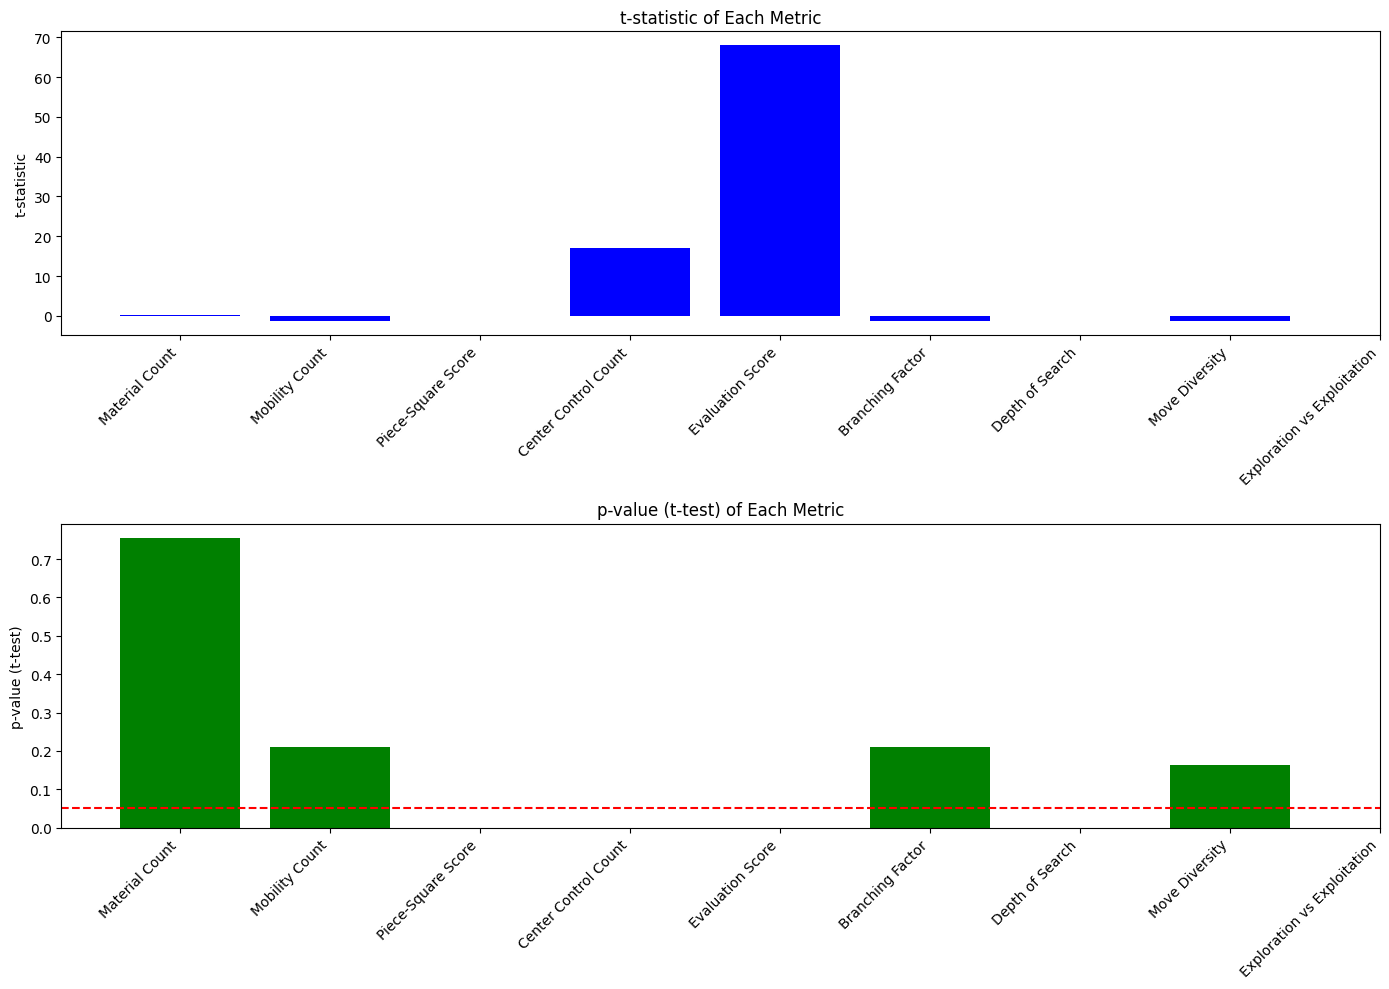

In [ ]:
# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)

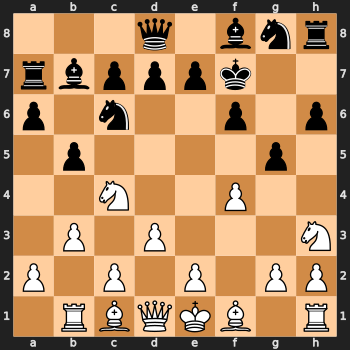

Move: g7f8, Step: 35, Time: 1.1921513080596924, Material: 32
Result: 1/2-1/2
Combined Probabilistic Mean Metrics:
 Material Count                  26.346154
Mobility Count                  25.653846
Piece-Square Score               0.000000
Center Control Count             0.692308
Evaluation Score                52.268654
Branching Factor                25.653846
Depth of Search                  3.000000
Move Diversity                 167.855769
Exploration vs Exploitation      0.000000
dtype: float64
Combined Probabilistic Std Metrics:
 Material Count                  3.673104
Mobility Count                  3.555751
Piece-Square Score              0.000000
Center Control Count            0.462131
Evaluation Score                3.117311
Branching Factor                3.555751
Depth of Search                 0.000000
Move Diversity                 44.282420
Exploration vs Exploitation     0.000000
dtype: float64

Combined Derandomized Mean Metrics:
 Material Count                  2

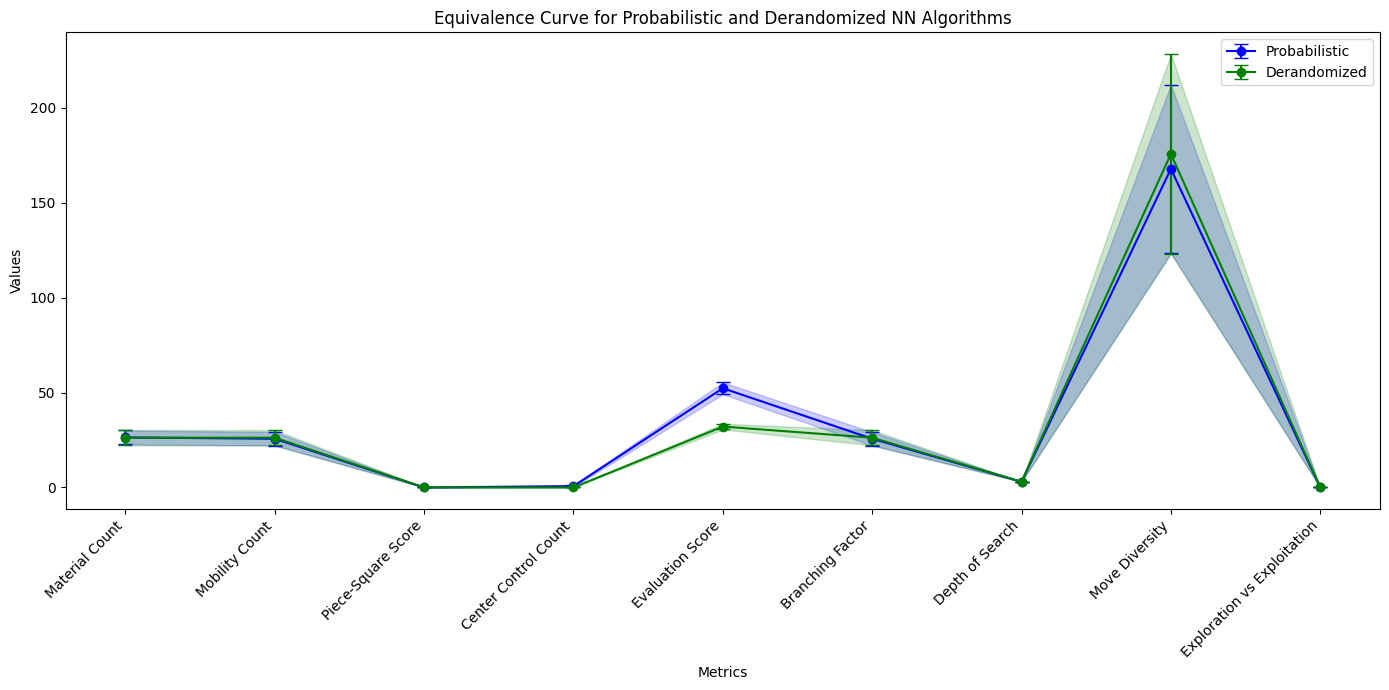

In [ ]:
# 9: Additional Games and Combined Metrics

# Run additional games to gather more data
additional_games = 10
probabilistic_results_additional, derandomized_results_additional = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=additional_games)

# Convert additional results to DataFrames
probabilistic_results_additional = [ensure_dataframe(df) for df in probabilistic_results_additional]
derandomized_results_additional = [ensure_dataframe(df) for df in derandomized_results_additional]

# Aggregate the additional data
probabilistic_mean_additional, probabilistic_std_additional, probabilistic_data_additional = aggregate_metrics(probabilistic_results_additional)
derandomized_mean_additional, derandomized_std_additional, derandomized_data_additional = aggregate_metrics(derandomized_results_additional)

# Combine the original and additional data
combined_probabilistic_data = pd.concat([probabilistic_data, probabilistic_data_additional], ignore_index=True)
combined_derandomized_data = pd.concat([derandomized_data, derandomized_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_probabilistic_mean = combined_probabilistic_data[numeric_columns].mean()
combined_probabilistic_std = combined_probabilistic_data[numeric_columns].std()
combined_derandomized_mean = combined_derandomized_data[numeric_columns].mean()
combined_derandomized_std = combined_derandomized_data[numeric_columns].std()

# Display the combined metrics
print("Combined Probabilistic Mean Metrics:\n", combined_probabilistic_mean)
print("Combined Probabilistic Std Metrics:\n", combined_probabilistic_std)
print("\nCombined Derandomized Mean Metrics:\n", combined_derandomized_mean)
print("Combined Derandomized Std Metrics:\n", combined_derandomized_std)

# Plot the equivalence curve again with combined data
plot_equivalence_curve(combined_probabilistic_mean, combined_probabilistic_std, combined_derandomized_mean, combined_derandomized_std)

In [ ]:
import numpy as np
import pandas as pd

# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Function to aggregate metrics
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    return mean_metrics, std_metrics, aggregated_data

# Example function to simulate games and collect results
def simulate_games(kane_class, seed, num_games=5):
    results = []
    for _ in range(num_games):
        board = chess.Board()
        kane = kane_class(board, seed)
        result = play_game_minimax_deterministic(kane) if kane_class.__name__ == 'KaneMinimaxDeterministic' else play_game_minimax_randomized(kane)
        results.append(ensure_dataframe(result))
    return results

# Assuming the classes KaneMinimaxDeterministic and KaneMinimaxRandomization are defined and the game play functions
# are play_game_minimax_deterministic and play_game_minimax_randomized are defined

# Simulate deterministic games
deterministic_results = simulate_games(KaneMinimaxDeterministic, seed=None)

# Simulate probabilistic (randomized) games
probabilistic_results = simulate_games(KaneMinimaxRandomization, seed=42)

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)

# Function to calculate the equivalence score
def calculate_equivalence_score(deterministic_data, probabilistic_data):
    metrics = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
               'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
               'Exploration vs Exploitation']
    
    # Number of instances
    N = len(deterministic_data)
    
    equivalence_scores = {}
    for metric in metrics:
        score_sum = 0
        for i in range(N):
            m_kane = deterministic_data[metric].iloc[i]
            m_abel = probabilistic_data[metric].iloc[i]
            if m_kane + m_abel == 0:
                score_sum += 0
            else:
                score_sum += abs(m_kane - m_abel) / (m_kane + m_abel)
        equivalence_scores[metric] = score_sum / N
    
    return equivalence_scores

# Calculate equivalence scores
equivalence_scores = calculate_equivalence_score(deterministic_data, probabilistic_data)

# Display the final equivalence scores
for metric, score in equivalence_scores.items():
    print(f"Equivalence score for {metric}: {score:.2f}")


NameError: name 'KaneMinimaxDeterministic' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6f51e1a-d40a-494a-8398-36807e7a81cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>